# Asteroid orbit optimization with PyGMO - Optimization
Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution  and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This tutorial is the third part of the Asteroid Orbit Optimization example. **This page reuses the** [Custom environment](https://tudat-space.readthedocs.io/en/latest/_src_getting_started/_src_examples/notebooks/pygmo/asteroid_orbit_optimization/aoo_custom_environment.html) **part of the example, without the explanation, after which an optimization is executed.**

## Problem recap
This aim of this tutorial is to illustrate the use of PyGMO to optimize an astrodynamics problem simulated with tudatpy. The problem describes the orbit design around a small body, the [Itokawa asteroid](https://en.wikipedia.org/wiki/25143_Itokawa).

The 4 design variables are:

- initial values of the semi-major axis.
- initial eccentricity.
- initial inclination.
- initial longitude of the ascending node.
 
The 2 objectives are:

- good coverage (maximizing the mean value of the absolute longitude w.r.t. Itokawa over the full propagation).
- good resolution (the mean value of the distance should be minimized).
 
The constraints are set on the altitude: all the sets of design variables leading to an orbit.

### NOTE
It is assumed that the reader of this tutorial is already familiar with the content of [this basic PyGMO tutorial](https://tudat-space.readthedocs.io/en/latest/_src_advanced_topics/optimization_pygmo.html). The full PyGMO documentation is available [on this website](https://esa.github.io/pygmo2/index.html). Be careful to read the
correct the documentation webpage (there is also a similar one for previous yet now outdated versions [here](https://esa.github.io/pygmo/index.html); as you can see, they can easily be confused).
PyGMO is the Python counterpart of [PAGMO](https://esa.github.io/pagmo2/index.html).

## Import statements

In [1]:
# Load standard modules
import os
import numpy as np
# Uncomment the following to make plots interactive
# %matplotlib widget
from matplotlib import pyplot as plt
from itertools import combinations as comb


# Load tudatpy modules
from tudatpy.io import save2txt
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice
from tudatpy.kernel.astro import element_conversion
from tudatpy.kernel.astro import frame_conversion
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
import tudatpy.util as util

# Load pygmo library
import pygmo as pg

current_dir = os.path.abspath('')

## Creation of Custom Environment

### Itokawa rotation settings

In [2]:
def get_itokawa_rotation_settings(itokawa_body_frame_name):
    # Definition of initial Itokawa orientation conditions through the pole orientation
    pole_declination = np.deg2rad(-66.30)     # Declination
    pole_right_ascension = np.deg2rad(90.53)  # Right ascension
    meridian_at_epoch = 0.0                   # Meridian

    # Define initial Itokawa orientation in inertial frame (equatorial plane)
    initial_orientation_j2000 = frame_conversion.inertial_to_body_fixed_rotation_matrix(
        pole_declination, pole_right_ascension, meridian_at_epoch)
    
    # Get initial Itokawa orientation in inertial frame but in the Ecliptic plane
    initial_orientation_eclipj2000 = np.matmul(spice.compute_rotation_matrix_between_frames(
        "ECLIPJ2000", "J2000", 0.0), initial_orientation_j2000)

    # Manually check the results, if desired
    check_results = False
    if check_results:
        np.set_printoptions(precision=100)
        print(initial_orientation_j2000)
    
        print(initial_orientation_eclipj2000)

    # Compute rotation rate
    rotation_rate = np.deg2rad(712.143) / constants.JULIAN_DAY

    # Set up rotational model for Itokawa with constant angular velocity
    return environment_setup.rotation_model.simple(
        "ECLIPJ2000", itokawa_body_frame_name, initial_orientation_eclipj2000, 0.0, rotation_rate)

### Itokawa ephemeris settings

In [3]:
def get_itokawa_ephemeris_settings(sun_gravitational_parameter):
    # Define Itokawa initial Kepler elements
    itokawa_kepler_elements = np.array([
        1.324118017407799 * constants.ASTRONOMICAL_UNIT,
        0.2801166461882852,
        np.deg2rad(1.621303507642802),
        np.deg2rad(162.8147699851312),
        np.deg2rad(69.0803904880264),
        np.deg2rad(187.6327516838828)])
    
    # Convert mean anomaly to true anomaly
    itokawa_kepler_elements[5] = element_conversion.mean_to_true_anomaly(
        eccentricity=itokawa_kepler_elements[1],
        mean_anomaly=itokawa_kepler_elements[5])
    
    # Get epoch of initial Kepler elements (in Julian Days)
    kepler_elements_reference_julian_day = 2459000.5
    
    # Sets new reference epoch for Itokawa ephemerides (different from J2000)
    kepler_elements_reference_epoch = (kepler_elements_reference_julian_day - constants.JULIAN_DAY_ON_J2000) \
                                      * constants.JULIAN_DAY
    
    # Sets the ephemeris model
    return environment_setup.ephemeris.keplerian(
        itokawa_kepler_elements,
        kepler_elements_reference_epoch,
        sun_gravitational_parameter,
        "Sun",
        "ECLIPJ2000")

### Itokawa gravity field settings

In [4]:
def get_itokawa_gravity_field_settings(itokawa_body_fixed_frame, itokawa_radius):
    itokawa_gravitational_parameter = 2.36
    normalized_cosine_coefficients = np.array([
        [1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0],
        [-0.145216, 0.0, 0.219420, 0.0, 0.0],
        [0.036115, -0.028139, -0.046894, 0.069022, 0.0],
        [0.087852, 0.034069, -0.123263, -0.030673, 0.150282]])
    normalized_sine_coefficients = np.array([
        [0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, -0.006137, -0.046894, 0.033976, 0.0],
        [0.0, 0.004870, 0.000098, -0.015026, 0.011627]])
    return environment_setup.gravity_field.spherical_harmonic(
        gravitational_parameter=itokawa_gravitational_parameter,
        reference_radius=itokawa_radius,
        normalized_cosine_coefficients=normalized_cosine_coefficients,
        normalized_sine_coefficients=normalized_sine_coefficients,
        associated_reference_frame=itokawa_body_fixed_frame)

### Itokawa shape settings

In [5]:
def get_itokawa_shape_settings(itokawa_radius):
    # Creates spherical shape settings
    return environment_setup.shape.spherical(itokawa_radius)

### Simulation bodies

In [6]:
def create_simulation_bodies(itokawa_radius):
    ### CELESTIAL BODIES ###
    # Define Itokawa body frame name
    itokawa_body_frame_name = "Itokawa_Frame"

    # Create default body settings for selected celestial bodies
    bodies_to_create = ["Sun", "Earth", "Jupiter", "Saturn", "Mars"]

    # Create default body settings for bodies_to_create, with "Earth"/"J2000" as
    # global frame origin and orientation. This environment will only be valid
    # in the indicated time range [simulation_start_epoch --- simulation_end_epoch]
    body_settings = environment_setup.get_default_body_settings(
        bodies_to_create,
        "SSB",
        "ECLIPJ2000")

    # Add Itokawa body
    body_settings.add_empty_settings("Itokawa")

    # Adds Itokawa settings
    # Gravity field
    body_settings.get("Itokawa").gravity_field_settings = get_itokawa_gravity_field_settings(itokawa_body_frame_name,
                                                                        itokawa_radius)
    # Rotational model
    body_settings.get("Itokawa").rotation_model_settings = get_itokawa_rotation_settings(itokawa_body_frame_name)
    # Ephemeris
    body_settings.get("Itokawa").ephemeris_settings = get_itokawa_ephemeris_settings(
        spice.get_body_gravitational_parameter( 'Sun') )
    # Shape (spherical)
    body_settings.get("Itokawa").shape_settings = get_itokawa_shape_settings(itokawa_radius)
    # Create system of selected bodies
    bodies = environment_setup.create_system_of_bodies(body_settings)

    ### VEHICLE BODY ###
    # Create vehicle object
    bodies.create_empty_body("Spacecraft")
    bodies.get("Spacecraft").set_constant_mass(400.0)

    # Create radiation pressure settings, and add to vehicle
    reference_area_radiation = 4.0
    radiation_pressure_coefficient = 1.2
    radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
        "Sun",
        reference_area_radiation,
        radiation_pressure_coefficient)
    environment_setup.add_radiation_pressure_interface(
        bodies,
        "Spacecraft",
        radiation_pressure_settings)

    return bodies

### Acceleration models

In [7]:
def get_acceleration_models(bodies_to_propagate, central_bodies, bodies):
    # Define accelerations acting on Spacecraft
    accelerations_settings_spacecraft = dict(
        Sun =     [ propagation_setup.acceleration.cannonball_radiation_pressure(),
                    propagation_setup.acceleration.point_mass_gravity() ],
        Itokawa = [ propagation_setup.acceleration.spherical_harmonic_gravity(3, 3) ],
        Jupiter = [ propagation_setup.acceleration.point_mass_gravity() ],
        Saturn =  [ propagation_setup.acceleration.point_mass_gravity() ],
        Mars =    [ propagation_setup.acceleration.point_mass_gravity() ],
        Earth =   [ propagation_setup.acceleration.point_mass_gravity() ]
    )

    # Create global accelerations settings dictionary
    acceleration_settings = {"Spacecraft": accelerations_settings_spacecraft}

    # Create acceleration models
    return propagation_setup.create_acceleration_models(
        bodies,
        acceleration_settings,
        bodies_to_propagate,
        central_bodies)

### Termination settings

In [8]:
def get_termination_settings(mission_initial_time, 
                             mission_duration,
                             minimum_distance_from_com,
                             maximum_distance_from_com):
    # Mission duration
    time_termination_settings = propagation_setup.propagator.time_termination(
        mission_initial_time + mission_duration,
        terminate_exactly_on_final_condition=False
    )
    # Upper altitude
    upper_altitude_termination_settings = propagation_setup.propagator.dependent_variable_termination(
        dependent_variable_settings=propagation_setup.dependent_variable.relative_distance('Spacecraft', 'Itokawa'),
        limit_value=maximum_distance_from_com,
        use_as_lower_limit=False,
        terminate_exactly_on_final_condition=False
    )
    # Lower altitude
    lower_altitude_termination_settings = propagation_setup.propagator.dependent_variable_termination(
        dependent_variable_settings=propagation_setup.dependent_variable.altitude('Spacecraft', 'Itokawa'),
        limit_value=minimum_distance_from_com,
        use_as_lower_limit=True,
        terminate_exactly_on_final_condition=False
    )

    # Define list of termination settings
    termination_settings_list = [time_termination_settings,
                                 upper_altitude_termination_settings,
                                 lower_altitude_termination_settings]

    return propagation_setup.propagator.hybrid_termination(termination_settings_list,
                                                           fulfill_single_condition=True)

### Dependent variables to save

In [9]:
def get_dependent_variables_to_save():
    dependent_variables_to_save = [
        propagation_setup.dependent_variable.central_body_fixed_spherical_position(
            "Spacecraft", "Itokawa"
        )
    ]
    return dependent_variables_to_save

## Optimisation problem formulation 

In [10]:
class AsteroidOrbitProblem:
    
    def __init__(self,
                 bodies,
                 propagator_settings,
                 mission_initial_time,
                 mission_duration,
                 design_variable_lower_boundaries,
                 design_variable_upper_boundaries):
        
        # Sets input arguments as lambda function attributes
        # NOTE: this is done so that the class is "pickable", i.e., can be serialized by pygmo
        self.bodies_function = lambda: bodies
        self.propagator_settings_function = lambda: propagator_settings
        
        # Initialize empty dynamics simulator
        self.dynamics_simulator_function = lambda: None
        
        # Set other input arguments as regular attributes
        self.mission_initial_time = mission_initial_time
        self.mission_duration = mission_duration
        self.mission_final_time = mission_initial_time + mission_duration
        self.design_variable_lower_boundaries = design_variable_lower_boundaries
        self.design_variable_upper_boundaries = design_variable_upper_boundaries

    def get_bounds(self):
        return (list(self.design_variable_lower_boundaries), list(self.design_variable_upper_boundaries))

    def get_nobj(self):
        return 2

    def fitness(self,
                orbit_parameters):
        # Retrieves system of bodies
        current_bodies = self.bodies_function()
        
        # Retrieves Itokawa gravitational parameter
        itokawa_gravitational_parameter = current_bodies.get("Itokawa").gravitational_parameter
        
        # Reset the initial state from the design variable vector
        new_initial_state = element_conversion.keplerian_to_cartesian_elementwise(
            gravitational_parameter=itokawa_gravitational_parameter,
            semi_major_axis=orbit_parameters[0],
            eccentricity=orbit_parameters[1],
            inclination=np.deg2rad(orbit_parameters[2]),
            argument_of_periapsis=np.deg2rad(235.7),
            longitude_of_ascending_node=np.deg2rad(orbit_parameters[3]),
            true_anomaly=np.deg2rad(139.87))
        
        # Retrieves propagator settings object
        propagator_settings = self.propagator_settings_function()
        
        # Reset the initial state
        propagator_settings.initial_states = new_initial_state

        # Propagate orbit
        dynamics_simulator = numerical_simulation.create_dynamics_simulator(current_bodies,
                                                                        propagator_settings)
        
        # Update dynamics simulator function
        self.dynamics_simulator_function = lambda: dynamics_simulator

        # Retrieve dependent variable history
        dependent_variables = dynamics_simulator.dependent_variable_history
        dependent_variables_list = np.vstack(list(dependent_variables.values()))
        
        # Retrieve distance
        distance = dependent_variables_list[:, 0]
        # Retrieve latitude
        latitudes = dependent_variables_list[:, 1]
        
        # Compute mean latitude
        mean_latitude = np.mean(np.absolute(latitudes))
        # Computes fitness as mean latitude
        current_fitness = 1.0 / mean_latitude

        # Exaggerate fitness value if the spacecraft has broken out of the selected distance range
        current_penalty = 0.0
        if (max(dynamics_simulator.dependent_variable_history.keys()) < self.mission_final_time):
            current_penalty = 1.0E2

        return [current_fitness + current_penalty, np.mean(distance) + current_penalty * 1.0E3]

    def get_last_run_dynamics_simulator(self):
        return self.dynamics_simulator_function()

### Setup orbital simulation


#### Simulation settings

In [11]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs
mission_initial_time = 0.0
mission_duration = 5.0 * constants.JULIAN_DAY

# Define Itokawa radius
itokawa_radius = 161.915

# Set altitude termination conditions
minimum_distance_from_com = 150.0 + itokawa_radius
maximum_distance_from_com = 5.0E3 + itokawa_radius

# Set boundaries on the design variables
design_variable_lb = (300, 0.0, 0.0, 0.0)
design_variable_ub = (2000, 0.3, 180, 360)

# Create simulation bodies
bodies = create_simulation_bodies(itokawa_radius)

# Define bodies to propagate and central bodies
bodies_to_propagate = ["Spacecraft"]
central_bodies = ["Itokawa"]

# Create acceleration models
acceleration_models = get_acceleration_models(bodies_to_propagate, central_bodies, bodies)

#### Dependent variables, termination settings, and orbit parameters

In [12]:
# Define list of dependent variables to save
dependent_variables_to_save = get_dependent_variables_to_save()

# Create propagation settings
termination_settings = get_termination_settings(
    mission_initial_time, mission_duration, minimum_distance_from_com, maximum_distance_from_com)

orbit_parameters = [1.20940330e+03, 2.61526215e-01, 7.53126558e+01, 2.60280587e+02]

#### Integrator and Propagator settings

In [13]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    initial_time_step=1.0,
    coefficient_set=propagation_setup.integrator.CoefficientSets.rkf_78,
    minimum_step_size=1.0E-6,
    maximum_step_size=constants.JULIAN_DAY,
    relative_error_tolerance=1.0E-8,
    absolute_error_tolerance=1.0E-8)

# Get current propagator, and define translational state propagation settings
propagator = propagation_setup.propagator.cowell
# Define propagation settings
initial_state = np.zeros(6)
propagator_settings = propagation_setup.propagator.translational(central_bodies,
                                                                         acceleration_models,
                                                                         bodies_to_propagate,
                                                                         initial_state,
                                                                         mission_initial_time,
                                                                         integrator_settings,
                                                                         termination_settings,
                                                                         propagator,
                                                                         dependent_variables_to_save)

## Optimisation run

**From here on out the example is new compared to the** [Custom environment](https://tudat-space.readthedocs.io/en/latest/_src_getting_started/_src_examples/notebooks/pygmo/asteroid_orbit_optimization/aoo_custom_environment.html) **part of the example.**

With the optimization problem and the simulation setup in hand, let's now run our optimization using PyGMO.

### Algorithm and problem definition
First, we define a fixed seed that PyGMO will use to generate random numbers. This ensures that the results can be reproduced. 

Then, the optimization problem is defined using the `AsteroidOrbitProblem` class initiated with the values that have already been defined. This User Defined Problem (UDP) is then given to PyGMO trough the `pg.problem()` method.

Finally, the optimizer is selected to be the Multi-objective EA vith Decomposition (MOAD) algorithm that is implemented in PyGMO. See [here](https://esa.github.io/pygmo2/algorithms.html#pygmo.moead) for its documentation.

In [14]:
# Fix seed for reproducibility
fixed_seed = 112987

# Instantiate orbit problem
orbitProblem = AsteroidOrbitProblem(bodies,
                                    propagator_settings,
                                    mission_initial_time,
                                    mission_duration,
                                    design_variable_lb,
                                    design_variable_ub)

# Create pygmo problem using the UDP instantiated above
prob = pg.problem(orbitProblem)

# Select Moead algorithm from pygmo, with one generation
algo = pg.algorithm(pg.nsga2(gen=1, seed=fixed_seed))

### Initial population
An initial population is now going to be generated by PyGMO, of a size of 48 individuals. This means that 48 orbital simulations will be run, and the fitness corresponding to the 48 individuals will be computed using the UDP.

In [15]:
# Initialize pygmo population with 48 individuals
population_size = 48
pop = pg.population(prob, size=population_size, seed=fixed_seed)

### Evolve population
We now want to make this population evolve, as to (hopefully) get closer to optimum solutions.

In a loop, we thus call `algo.evolve(pop)` 25 times to make the population evolve 25 times. During each generation, we also save the list of fitness and of design variables.

In [16]:
# Set the number of evolutions
number_of_evolutions = 25

# Initialize containers
fitness_list = []
population_list = []

# Evolve the population recursively
for gen in range(number_of_evolutions):
    print("Evolving population; at generation %i/%i" % (gen, number_of_evolutions-1), end="\r")
    
    # Evolve the population
    pop = algo.evolve(pop)
    
    # Store the fitness values and design variables for all individuals
    fitness_list.append(pop.get_f())
    population_list.append(pop.get_x())
    
print("Evolving population is finished")

Evolving population is finishedion 24/24


### Results analysis
With the population evolved, the optimization is finished. We can now analyse the results to see how our optimization was carried, and what our optimum solutions are.

#### Extract results
First of, we want to save the state and dependent variable history of the orbital simulations that were carried in the first and last generations. To do so, we extract the design variables of all the member of a given population, and we run the orbital simulation again, calling the `orbitProblem.fitness()` function. Then, we can extract the state and dependent variable history by calling the `orbitProblem.get_last_run_dynamics_simulator()` function.

In [17]:
# Retrieve first and last generations for further analysis
pops_to_analyze = {0: 'initial',
                   number_of_evolutions - 1 : 'final'}

# Initialize containers
simulation_output = dict()

# Loop over first and last generations
for population_index, population_name in pops_to_analyze.items():
    
    # Get population individuals from the given generation
    current_population = population_list[population_index]
    
    # Current generation's dictionary
    generation_output = dict()
    
    # Loop over all individuals of the populations
    for individual in range(population_size):

        # Retrieve orbital parameters
        current_orbit_parameters = current_population[individual]
        
        # Propagate orbit and compute fitness
        orbitProblem.fitness(current_orbit_parameters)
        
        # Retrieve state and dependent variable history
        current_states = orbitProblem.get_last_run_dynamics_simulator().state_history
        current_dependent_variables = orbitProblem.get_last_run_dynamics_simulator().dependent_variable_history
        
        # Save results to dict
        generation_output[individual] = [current_states, current_dependent_variables]
        
    # Append to global dictionary
    simulation_output[population_index] = [generation_output,
                                           fitness_list[population_index],
                                           population_list[population_index]]

#### Pareto fronts
As a first analysis of the optimization results, let's plot the Pareto fronts, to represent the optimums.

This is done for the first and last generation, plotting the score of the two objectives for all of the population members. A colormap is also used to represent the value of the design variables selected by the optimiser. Finally, the Pareto front is plotted in green, showing the limit of the attainable optimum solutions. 


These Pareto fronts show that both of the objectives were successfully improved after 25 generations, attaining lower values for both of them.

We can also notice that the population is packed closer to the Pareto front after 25 generations. At the opposite, the population was covering a higher area of the design space for the first generation.

In [18]:
# Create dictionaries defining the design variables
design_variable_names = {0: 'Semi-major axis [m]',
                           1: 'Eccentricity',
                           2: 'Inclination [deg]',
                           3: 'Longitude of the node [deg]'}
design_variable_range = {0: [800.0, 1300.0],
                           1: [0.10, 0.17],
                           2: [90.0, 95.0],
                           3: [250.0, 270.0]}
design_variable_symbols = {0: r'$a$',
                             1: r'$e$',
                             2: r'$i$',
                             3: r'$\Omega$'}
design_variable_units = {0: r' m',
                           1: r' ',
                           2: r' deg',
                           3: r' deg'}

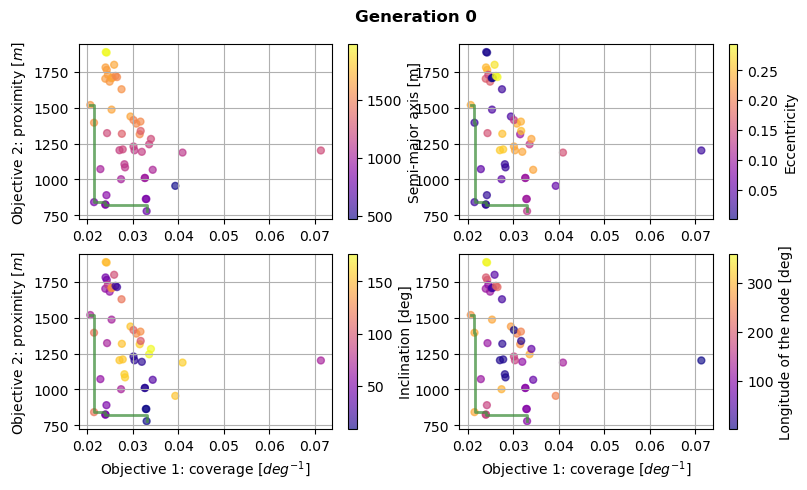

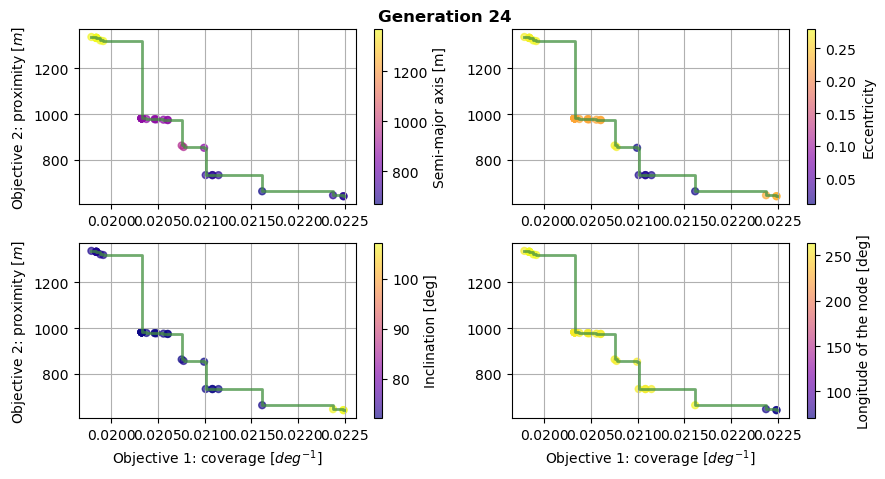

In [19]:
# Loop over populations
for population_index in simulation_output.keys():
    
    # Retrieve current population
    current_generation = simulation_output[population_index]
    
    # Plot Pareto fronts for all design variables
    fig, axs = plt.subplots(2, 2, figsize=(9, 5))
    fig.suptitle('Generation ' + str(population_index), fontweight='bold', y=0.95)
    current_fitness = current_generation[1]
    current_population = current_generation[2]
    for ax_index, ax in enumerate(axs.flatten()):
        # Plot all the population at given generation
        cs = ax.scatter(np.deg2rad(current_fitness[:, 0]),
                        current_fitness[:, 1],
                        s=100,
                        c=current_population[:, ax_index],
                        marker='.',
                        cmap="plasma",
                        alpha=0.65)
        
        # Plot the design variable using a colormap
        cbar = fig.colorbar(cs, ax=ax)
        cbar.ax.set_ylabel(design_variable_names[ax_index])
        
        # Add a label only on the left-most and bottom-most axes
        ax.grid('major')
        if ax_index > 1:
            ax.set_xlabel(r'Objective 1: coverage [$deg^{-1}$]')
        if ax_index == 0 or ax_index == 2:
            ax.set_ylabel(r'Objective 2: proximity [$m$]')
            
        # Add the Pareto fron itself in green
        optimum_mask = util.pareto_optimums(np.array([np.deg2rad(current_fitness[:, 0]), current_fitness[:, 1]]).T)
        ax.step(
            sorted(np.deg2rad(current_fitness[:, 0])[optimum_mask], reverse=True),
            sorted(current_fitness[:, 1][optimum_mask], reverse=False),
            color="#418F3E",
            linewidth=2,
            alpha=0.75)
        
# Show the figure
plt.tight_layout()
plt.show()

#### Design variables histogram
Plotting the histogram of the design variables for the final generation gives insights into what set of orbital parameters lead to optimum solutions. Possible optimum design variables values can then be detected by looking at the number of population members that use them. A high number of occurences in the final generation **could** indicate a better design variable. At least, this offers some leads into what to investigate further.

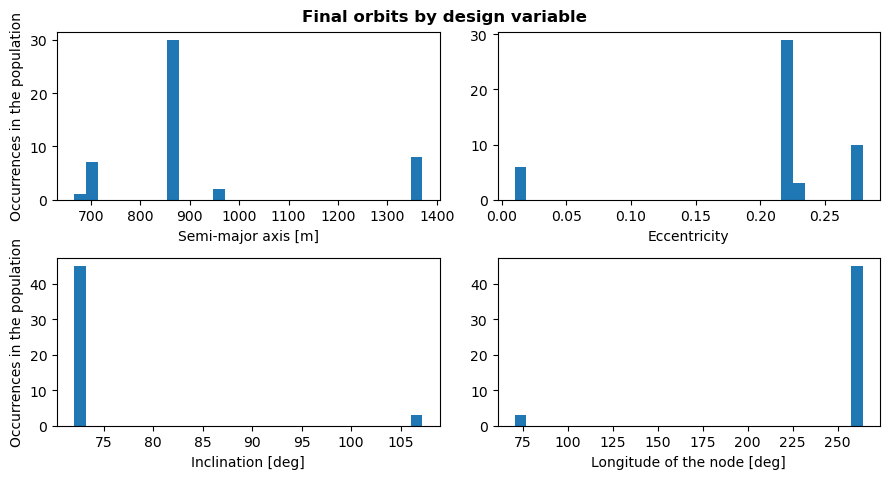

In [20]:
# Plot histogram for last generation, semi-major axis
fig, axs = plt.subplots(2, 2, figsize=(9, 5))
fig.suptitle('Final orbits by design variable', fontweight='bold', y=0.95)
last_pop = simulation_output[number_of_evolutions - 1][2]

for ax_index, ax in enumerate(axs.flatten()):
    ax.hist(last_pop[:, ax_index], bins=30)
    
    # Prettify
    ax.set_xlabel(design_variable_names[ax_index])
    if ax_index % 2 == 0:
        ax.set_ylabel('Occurrences in the population')
        
# Show the figure
plt.tight_layout()
plt.show()

#### Initial and final orbits visualisation
One may now want to see how much better the optimized orbits are compared to the ones of the random initial population. This can be done by plotting the orbit bundles from the initial and final generations.

The resulting 3D plot show the chaotic nature of the initial random population, where the last generation appears to use a handfull of variations of the similar design variables.

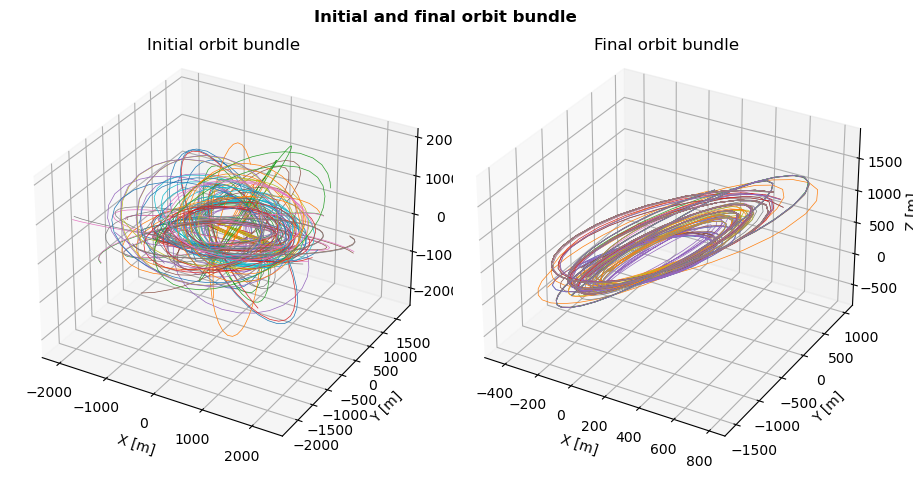

In [21]:
# Plot orbits of initial and final generation
fig = plt.figure(figsize=(9, 5))
fig.suptitle('Initial and final orbit bundle', fontweight='bold', y=0.95)
title = {0: 'Initial orbit bundle',
         1: 'Final orbit bundle'}

# Loop over populations
for ax_index, population_index in enumerate(simulation_output.keys()):
    current_ax = fig.add_subplot(1, 2, 1 + ax_index, projection='3d')
    
    # Retrieve current population
    current_generation = simulation_output[population_index]
    current_population = current_generation[2]
    
    # Loop over individuals
    for ind_index, individual in enumerate(current_population):
        
        # Plot orbit
        state_history = list(current_generation[0][ind_index][0].values())
        state_history = np.vstack(state_history)
        current_ax.plot(state_history[:, 0],
                        state_history[:, 1],
                        state_history[:, 2],
                        linewidth=0.5)
        
    # Prettify
    current_ax.set_xlabel('X [m]')
    current_ax.set_ylabel('Y [m]')
    current_ax.set_zlabel('Z [m]')
    current_ax.set_title(title[ax_index], y=1.0, pad=15)

# Show the figure
plt.tight_layout()
plt.show()

#### Orbits visualization by design variable
Finally, we can visualize what range of design variables lead to which type of orbits. This is done by plotting the bundle of orbits for the last generation.

This plot one again shows that the orbits from the final population can be sub-categorized into disctinct orbital configurations.

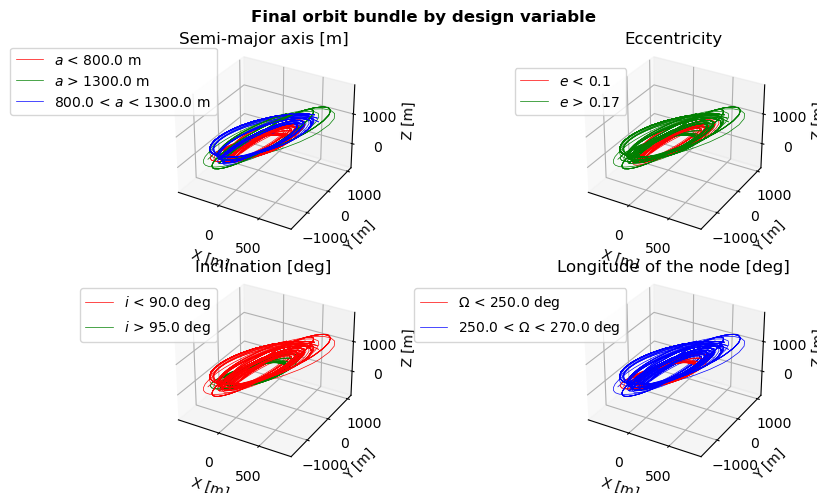

In [22]:
# Plot orbits of final generation divided by parameters
fig = plt.figure(figsize=(9, 5))
fig.suptitle('Final orbit bundle by design variable', fontweight='bold', y=0.95)

# Retrieve current population
current_generation = simulation_output[number_of_evolutions - 1]

# Plot Pareto fronts for all design variables
current_population = current_generation[2]

# Loop over design variables
for var in range(4):
    
    # Create axis
    current_ax = fig.add_subplot(2, 2, 1 + var, projection='3d')
    
    # Loop over individuals
    for ind_index, individual in enumerate(current_population):
        
        # Set plot color according to boundaries
        if individual[var] < design_variable_range[var][0]:
            plt_color = 'r'
            label = design_variable_symbols[var] + ' < ' + str(design_variable_range[var][0]) + \
                    design_variable_units[var]
        elif design_variable_range[var][0] < individual[var] < design_variable_range[var][1]:
            plt_color = 'b'
            label = str(design_variable_range[var][0]) + ' < ' + \
                    design_variable_symbols[var] + \
                    ' < ' + str(design_variable_range[var][1]) + design_variable_units[var]
        else:
            plt_color = 'g'
            label = design_variable_symbols[var] + ' > ' + str(design_variable_range[var][1]) + \
                    design_variable_units[var]

        # Plot orbit
        state_history = list(current_generation[0][ind_index][0].values())
        state_history = np.vstack(state_history)
        current_ax.plot(state_history[:, 0],
                        state_history[:, 1],
                        state_history[:, 2],
                        color=plt_color,
                        linewidth=0.5,
                        label=label)
        
    # Prettify
    current_ax.set_xlabel('X [m]')
    current_ax.set_ylabel('Y [m]')
    current_ax.set_zlabel('Z [m]')
    current_ax.set_title(design_variable_names[var], y=1.0, pad=10)
    handles, design_variable_legend = current_ax.get_legend_handles_labels()
    design_variable_legend, ids = np.unique(design_variable_legend, return_index=True)
    handles = [handles[i] for i in ids]
    current_ax.legend(handles, design_variable_legend, loc='lower right', bbox_to_anchor=(0.3, 0.6))
    
# Show the figure
plt.tight_layout()
plt.show()